In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from utils import data_utils

import importlib
importlib.reload(data_utils)

RUN_FOLDER = "../results/debug/"

In [2]:
kcm_model_results = data_utils.load_pkl(RUN_FOLDER + "kcm/" + "model_results.pkl")
atb_model_results = data_utils.load_pkl(RUN_FOLDER + "atb/" + "model_results.pkl")
kcm_result_df, kcm_loss_df = data_utils.extract_results("Seattle", kcm_model_results)
atb_result_df, atb_loss_df = data_utils.extract_results("Trondheim", atb_model_results)

performances_df = pd.concat([kcm_result_df, atb_result_df], axis=0).sort_values(['Model','City','Fold'])
model_curves_df = pd.concat([kcm_loss_df, atb_loss_df], axis=0)

print(f"All Unique Models: {pd.unique(performances_df['Model'])}")
print(f"All NN Models: {pd.unique(model_curves_df['Model'])}")

All Unique Models: ['AVG' 'FF' 'GRU_RNN' 'GRU_RNN_NOPACK' 'PER' 'RNN_SPD' 'SCH']
All NN Models: ['FF' 'RNN_SPD' 'GRU_RNN_NOPACK' 'GRU_RNN']


In [3]:
# kcm_model_results = data_utils.load_pkl(RUN_FOLDER + "kcm/" + "model_results.pkl")
# atb_model_results = data_utils.load_pkl(RUN_FOLDER + "atb/" + "model_results.pkl")
# kcm_result_df, kcm_loss_df = data_utils.extract_results("Seattle", kcm_model_results)
# atb_result_df, atb_loss_df = data_utils.extract_results("Trondheim", atb_model_results)

# kcm_deeptte_results = data_utils.extract_deeptte_results("Seattle", RUN_FOLDER, "kcm/")
# atb_deeptte_results = data_utils.extract_deeptte_results("Trondheim", RUN_FOLDER, "atb/")
# kcm_deeptte_result_df = kcm_deeptte_results[['Model','City','Fold','MAPE','RMSE','MAE']].copy()
# atb_deeptte_result_df = atb_deeptte_results[['Model','City','Fold','MAPE','RMSE','MAE']].copy()

# performances_df = pd.concat([kcm_result_df, atb_result_df, kcm_deeptte_result_df, atb_deeptte_result_df], axis=0).sort_values(['Model','City','Fold'])
# model_curves_df = pd.concat([kcm_loss_df, atb_loss_df], axis=0)

# print(f"All Unique Models: {pd.unique(performances_df['Model'])}")
# print(f"All NN Models: {pd.unique(model_curves_df['Model'])}")

In [4]:
# fig, axes = plt.subplots(1,1)
# fig.set_figheight(4)
# fig.set_figwidth(5)
# sns.lineplot(kcm_deeptte_results, x="Epoch", y="MAPE", hue="Loss Set", ax=axes)
# fig.suptitle('KCM DeepTTE Loss', fontsize=16)
# fig.tight_layout()
# plt.savefig("../plots/model_curves_deeptte_kcm.png", dpi=1800, bbox_inches='tight')

In [5]:
# fig, axes = plt.subplots(1,1)
# fig.set_figheight(4)
# fig.set_figwidth(5)
# sns.lineplot(atb_deeptte_results, x="Epoch", y="MAPE", hue="Loss Set", ax=axes)
# fig.suptitle('AtB DeepTTE Loss', fontsize=16)
# fig.tight_layout()
# plt.savefig("../plots/model_curves_deeptte_atb.png", dpi=1800, bbox_inches='tight')

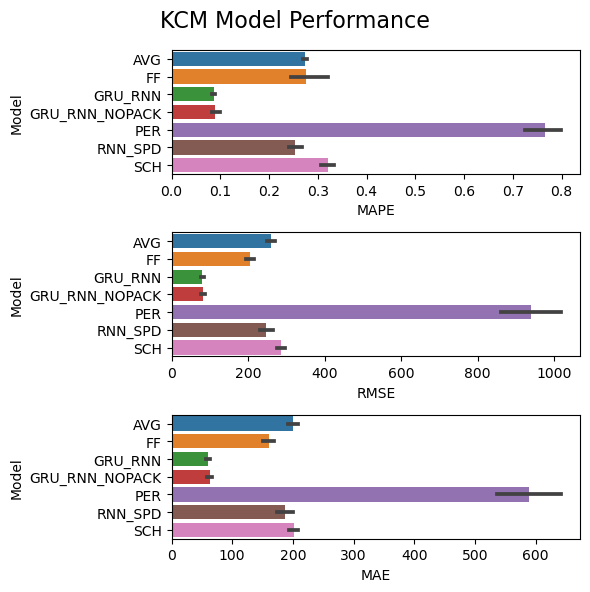

In [13]:
plot_data = performances_df[performances_df['City']=="Seattle"]
fig, axes = plt.subplots(3,1)
fig.set_figheight(6)
fig.set_figwidth(6)
sns.barplot(plot_data, x="MAPE", y="Model", ax=axes[0])
sns.barplot(plot_data, x="RMSE", y="Model", ax=axes[1])
sns.barplot(plot_data, x="MAE", y="Model", ax=axes[2])
fig.suptitle('KCM Model Performance', fontsize=16)
fig.tight_layout()
plt.savefig("../plots/model_performances_kcm.png", dpi=1800, bbox_inches='tight')

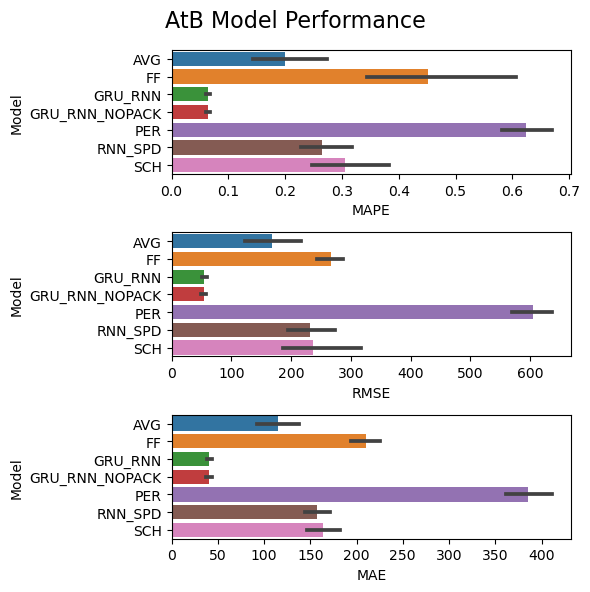

In [11]:
plot_data = performances_df[performances_df['City']=="Trondheim"]
fig, axes = plt.subplots(3,1)
fig.set_figheight(6)
fig.set_figwidth(6)
sns.barplot(plot_data, x="MAPE", y="Model", ax=axes[0])
sns.barplot(plot_data, x="RMSE", y="Model", ax=axes[1])
sns.barplot(plot_data, x="MAE", y="Model", ax=axes[2])
fig.suptitle('AtB Model Performance', fontsize=16)
fig.tight_layout()
plt.savefig("../plots/model_performances_atb.png", dpi=1800, bbox_inches='tight')

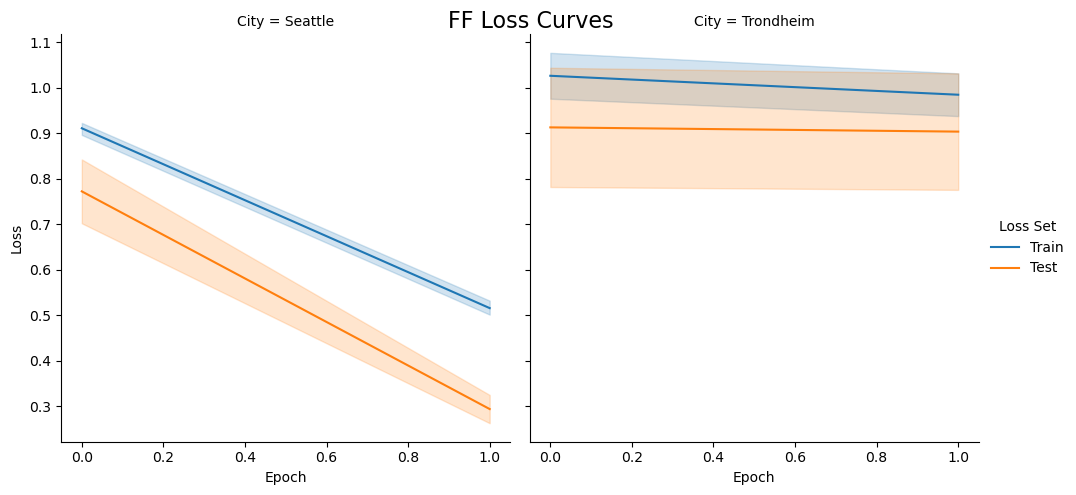

In [6]:
model_name = "FF"
plot_data = model_curves_df[model_curves_df['Model']==model_name]
g = sns.relplot(data=plot_data, x="Epoch", y="Loss", hue="Loss Set", col="City", kind="line")
g.fig.suptitle(f"{model_name} Loss Curves", fontsize=16)
plt.savefig(f"../plots/model_curves_{model_name}.png", dpi=1800, bbox_inches='tight')

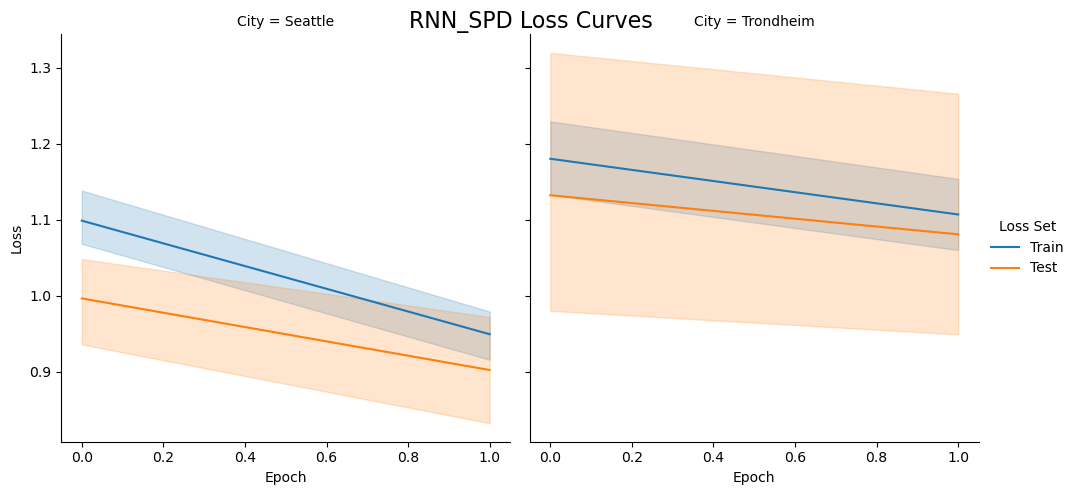

In [7]:
model_name = "RNN_SPD"
plot_data = model_curves_df[model_curves_df['Model']==model_name]
g = sns.relplot(data=plot_data, x="Epoch", y="Loss", hue="Loss Set", col="City", kind="line")
g.fig.suptitle(f"{model_name} Loss Curves", fontsize=16)
plt.savefig(f"../plots/model_curves_{model_name}.png", dpi=1800, bbox_inches='tight')

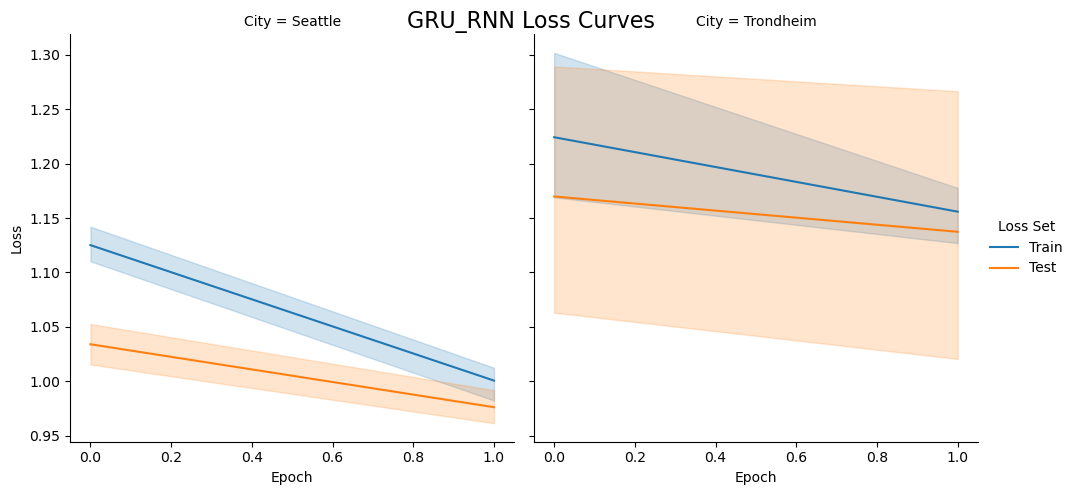

In [8]:
model_name = "GRU_RNN"
plot_data = model_curves_df[model_curves_df['Model']==model_name]
g = sns.relplot(data=plot_data, x="Epoch", y="Loss", hue="Loss Set", col="City", kind="line")
g.fig.suptitle(f"{model_name} Loss Curves", fontsize=16)
plt.savefig(f"../plots/model_curves_{model_name}.png", dpi=1800, bbox_inches='tight')

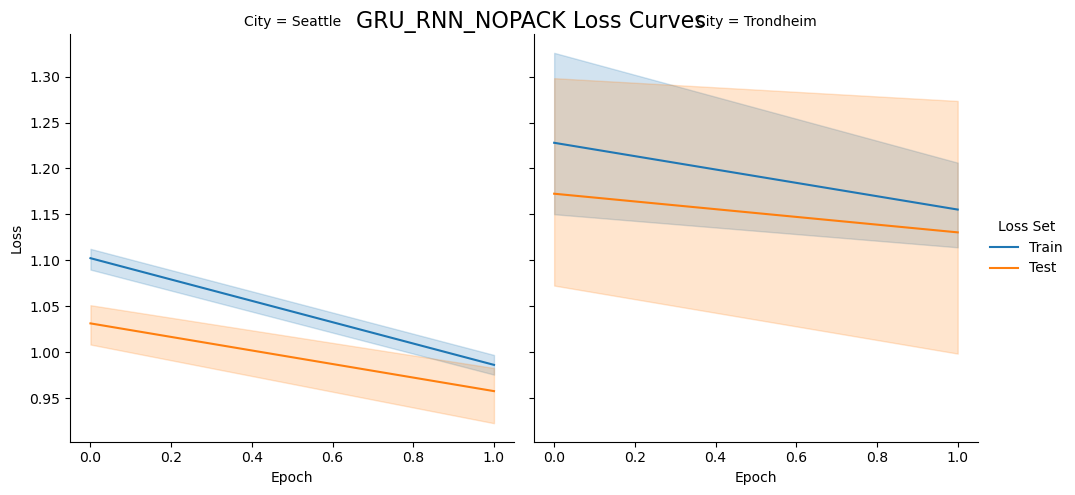

In [9]:
model_name = "GRU_RNN_NOPACK"
plot_data = model_curves_df[model_curves_df['Model']==model_name]
g = sns.relplot(data=plot_data, x="Epoch", y="Loss", hue="Loss Set", col="City", kind="line")
g.fig.suptitle(f"{model_name} Loss Curves", fontsize=16)
plt.savefig(f"../plots/model_curves_{model_name}.png", dpi=1800, bbox_inches='tight')